# Toy Simulation of CAST model

The goal of this notebook os to illustrate how to implement a *CAST* model in the case of a disease propagation (epidemic). Some of the parameters here come from the situation in France. See the [README](README.md) for more details about the *CAST* model.

In [1]:
from numpy import array, around, ones, concatenate, where, linspace, zeros, frombuffer
from numpy.random import choice, beta, uniform
from pprint import pprint
from time import time
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from itertools import product
import seaborn as sns
import os, imageio, sys
from IPython.display import HTML

sys.path.append('..')
from classes import State, Agent, Cell, Map

# If doesn't exist, create path to store images
img_path = os.path.join('..', 'img')
if not os.path.exists(img_path):
    os.makedirs(img_path)

## States 
### Attributes
Each state has three *attributes*, all taking value between 0 and 1:

1. *contagiousity*: influences (linearly) the probability that an agent in this state infects other agents in the same cell
2. *sensitivity*: influences (linearly) the probability for an agent in this state gets infected from a sick agent in the same cell
3. *severity*: influences (inverse linearly) the probability that an agent in this state will move to another cell

### Definitions
We define seven states:

1. *healthy*: not contagious but very sensitive
2. *asymptomatic*: contagious but insensitive (since already infected), very low severity
3. *mild*: same as asymptomatic, but with higher severity
4. *hospital*: agent in the hospital. Same as mild and symptomatic, but with highest severity (can't move)
5. *reanimation*: same attribute values that *hospital*
6. *dead*: sensitivity and contagiousity are 0, severity is maximal (1, can't move)
7. *recovered*: same as *healthy* but not sensitive (considered completely immune as an approximation)

In [2]:
state0 = State(id=0, name='healthy', contagiousity=0, sensitivity=1, severity=0)
state1 = State(id=1, name='asymptomatic', contagiousity=.05, sensitivity=0, severity=0.1)
state2 = State(id=2, name='mild', contagiousity=.15, sensitivity=0, severity=0.8)
state3 = State(id=3, name='hospital', contagiousity=.1, sensitivity=0, severity=1)
state4 = State(id=4, name='reanimation', contagiousity=.05, sensitivity=0, severity=1)
state5 = State(id=5, name='dead', contagiousity=0, sensitivity=0, severity=1)
state6 = State(id=6, name='recovered', contagiousity=0, sensitivity=0, severity=0)

states = [state0, state1, state2, state3, state4, state5, state6]
id2state = {state.get_id(): state.get_name() for state in states}

### Transitions
The *transition*s describe the probability of transitioning by itself from one state to another, without considering cases of infection. As we have 7 *state*s, each transition is a 7x7 matrix. The element $(i, j)$ of such a matrix attached to an agent is the probability for this agent to transition forom state $i$ to state $j$. For example $(3, 7)$ is the probability to transition from *mild* to *recovered*.

Each *agent* can have its own transition matrix, but here to simplify we define just a few correspondig to various categories of population:

In [3]:
# For people younger than 15yo
transitions_15 = array([[1, 0, 0, 0, 0, 0, 0], 
                     [0, 0, 0.5, 0, 0, 0, 0.5], 
                     [0, 0, 0, 0.3, 0, 0, 0.7],
                     [0, 0, 0, 0, 0.3, 0, 0.7],
                     [0, 0, 0, 0, 0, 0.5, 0.5],
                     [0, 0, 0, 0, 0, 1, 0],
                     [0, 0, 0, 0, 0, 0, 1]])

# For people younger between 15 and 44yo
transitions_15_44 = array([[1, 0, 0, 0, 0, 0, 0], 
                     [0, 0, 0.5, 0, 0, 0, 0.5], 
                     [0, 0, 0, 0.3, 0, 0, 0.7],
                     [0, 0, 0, 0, 0.3, 0, 0.7],
                     [0, 0, 0, 0, 0, 0.5, 0.5],
                     [0, 0, 0, 0, 0, 1, 0],
                     [0, 0, 0, 0, 0, 0, 1]])

# For people younger between 45 and 64yo
transitions_45_64 = array([[1, 0, 0, 0, 0, 0, 0], 
                     [0, 0, 0.5, 0, 0, 0, 0.5], 
                     [0, 0, 0, 0.3, 0, 0, 0.7],
                     [0, 0, 0, 0, 0.3, 0, 0.7],
                     [0, 0, 0, 0, 0, 0.5, 0.5],
                     [0, 0, 0, 0, 0, 1, 0],
                     [0, 0, 0, 0, 0, 0, 1]])

# For people younger between 65 and 75yo
transitions_65_74 = array([[1, 0, 0, 0, 0, 0, 0], 
                     [0, 0, 0.5, 0, 0, 0, 0.5], 
                     [0, 0, 0, 0.3, 0, 0, 0.7],
                     [0, 0, 0, 0, 0.3, 0, 0.7],
                     [0, 0, 0, 0, 0, 0.5, 0.5],
                     [0, 0, 0, 0, 0, 1, 0],
                     [0, 0, 0, 0, 0, 0, 1]])

# For people younger >= 75yo
transitions_75 = array([[1, 0, 0, 0, 0, 0, 0], 
                     [0, 0, 0.5, 0, 0, 0, 0.5], 
                     [0, 0, 0, 0.3, 0, 0, 0.7],
                     [0, 0, 0, 0, 0.3, 0, 0.7],
                     [0, 0, 0, 0, 0, 0.5, 0.5],
                     [0, 0, 0, 0, 0, 1, 0],
                     [0, 0, 0, 0, 0, 0, 1]])

transitions = [transitions_15, transitions_15_44, transitions_45_64, transitions_65_74, transitions_75]

In [4]:
# TODO: check statistics to get more realistic transition matrices

## Agents
We create 1000 *agent*s in this simulation.

`prop_population` define the proportion of the French population in the age classes defined for the transitions, approximated from the [French population pyramid](http://perspective.usherbrooke.ca/bilan/servlet/BMPagePyramide?codePays=FRA&annee=2018) in 2018.

The age class of each *agent* is drawn randomly according to those proportions, and its transition matrix corresponds to its drawn age class.

*Remark:* This simulation could be refined by defining more granular demographics (by genders, health history etc.) and corresponding transitions.

In [5]:
N_AGENTS = 1000

In [6]:
prop_population = [.17, .35, .3, .1, .08]
draw_transitions = choice(range(len(transitions)), N_AGENTS, p=prop_population)

Each *agent* has durations corresponding to each state it can take. For each *agent* we draw them according to a [beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) with min, max and mean value corresponding approximatively to available statistics:

In [7]:
def get_alpha_beta(min_value, max_value, mean_value):
    """ for the duration on a state, draw from a beta distribution with parameter alpha and beta """
    x = (mean_value - min_value) / (max_value - min_value)
    z = 1 / x - 1
    a, b = 2, 2 * z
    return a, b


def draw_beta_durations(min_value, max_value, mean_value, n_values):
    """ draw `n_values` values between `min_value` and `max_value` having 
    `mean_value` as (asymptotical) average"""
    a, b = get_alpha_beta(min_value, max_value, mean_value)
    durations = beta(a, b, n_values) * (max_value - min_value) + min_value
    return around(durations).reshape(-1, 1)

In [8]:
durations_healthy = durations_dead = durations_recovered = ones(shape=(N_AGENTS, 1)) * -1
durations_asymptomatic = draw_beta_durations(1, 14, 5, N_AGENTS)
durations_mild = draw_beta_durations(5, 10, 7, N_AGENTS)
durations_hospital = draw_beta_durations(1, 8, 4, N_AGENTS)
durations_reanimation = draw_beta_durations(15, 30, 21, N_AGENTS)

durations = [durations_healthy, durations_asymptomatic, durations_mild, 
             durations_hospital, durations_reanimation, durations_dead, durations_recovered]

durations = concatenate(durations, axis=1)

# Check if the shape of `durations` is OK
shape_durations_ok = (durations.shape == (N_AGENTS, len(states)))
print(f'durations.shape: {durations.shape}, OK? {shape_durations_ok}')

durations.shape: (1000, 7), OK? True


The parameter `p_move` representing the probability for an *agent* to be selected (if healthy) for a movement is drawn uniformly randomly, without consideration for the age or whatever of the *agent* (*Remark*: that could be also a possibility of refinement):

In [9]:
p_moves = uniform(size=N_AGENTS)

In France there are in average 2.2 people living per home. So we consider the first $N\_AGENTS / 2.2$ *cell*s to be home *cell*s, and dispatch those home *cell*s randomly among the *agent*s:

In [10]:
AVG_AGENTS_HOME = 2.2

n_home_cells = int(N_AGENTS / AVG_AGENTS_HOME)
draw_home_cells = choice(range(n_home_cells), N_AGENTS)

And now we create the *agent*s according to those parameters:

In [11]:
agents = []
for i in range(N_AGENTS):
    agent = Agent(id=i, p_move=p_moves[i], 
                  transitions=transitions[draw_transitions[i]], 
                  states=states, 
                  durations=durations[i,:].flatten(), 
                  current_state=state0, 
                  home_cell_id=draw_home_cells[i])
    agents.append(agent)

## Cells
Here we consider 500 cells, randomly uniformly distributed on a 100x100 surface:

In [12]:
N_CELLS = 500

In [13]:
positions_x = uniform(low=0, high=100, size=N_CELLS).reshape(-1, 1)
positions_y = uniform(low=0, high=100, size=N_CELLS).reshape(-1, 1)

positions = concatenate([positions_x, positions_y], axis=1)

Their attractivity is randomly uniformly distributed between 0 and 1, besides home *cell*s, that have a fixed attractivity of 0.1. The idea behind it is that home *cell*s are not very attractive for agents for which it's not the home *cell*.

In [14]:
attractivities = uniform(size=N_CELLS)
attractivities[:n_home_cells] = .1

Their unsafety is randomly uniformly distributed between 0 and 1, besides home *cell*s, that have a fixed unsafety of 1. The idea behind it is that home *cell*s are are very unsafe (no social distancing at home).

In [15]:
unsafeties = uniform(size=N_CELLS)
unsafeties[:n_home_cells] = 1

Now we create the *cell*s with those parameters:

In [16]:
cells = []
for i in range(N_CELLS):
    cell = Cell(id=i, 
                position=positions[i,:].flatten(), 
                attractivity=attractivities[i], 
                unsafety=unsafeties[i], 
                agents=[agents[j] for j in where(draw_home_cells == i)[0]])
    cells.append(cell)

## Map
Now we create a *map* containing the *agent*s and *cell*s created above:

In [17]:
possible_state_ids = [state.get_id() for state in states]

map = Map(cells, agents, possible_state_ids, verbose=0)

## Simulation
Now that the context is set up, we can run simulations.

### Number of agents in each state through time
Here we first chose an agent at random in the map getting infected. Then the agents on the map move, get infected, their state evolve. At each time period we count the number of agents in each state, and finally plot this evolution.

First we chose one agent at random that gets infected:

In [18]:
infected_agent_id = choice(range(N_AGENTS))
map.get_agent(infected_agent_id).get_infected()

Then we run a simulation over 60 time periods (days) having each 3 move rounds. For each time period, we print the repartition of the population among the states, and the *R* factor:

In [19]:
N_PERIODS = 60
N_MOVES_PER_PERIOD = 3

periods_states = {}
t_start = time()
for i in range(N_PERIODS):
    for j in range(N_MOVES_PER_PERIOD):
        map.make_move()
    map.forward_all_cells()
    states_repartition = map.get_states_numbers()
    states_repartition = {id2state.get(k): v for k, v in states_repartition.items()}
    r = map.get_r()
    period_state = {'repartition': states_repartition, 'r': r}
    periods_states[i] = period_state
    
    
print(f'all {N_PERIODS} periods computed in {round(time() - t_start, 3)}s')
    

all 60 periods computed in 5.949s


**NB:** 
* The *R* factor is at the end negative, due to the agents that recovered. The calculation of *R* should probably be redefined to take account of this
* The number of healthy people gets stable at 5 at the end, means the heard immunity is reached aftercalculation 99.5% of the population got infected. The set up and/or the parameters have to be modified to get a more realistic value of around 70%
* The simulation runs quite fast, there is room to increase the population and the number of cells in the map

Now we plot the data we obtained through the simulation, means the repartition of the population among states through time:

[]

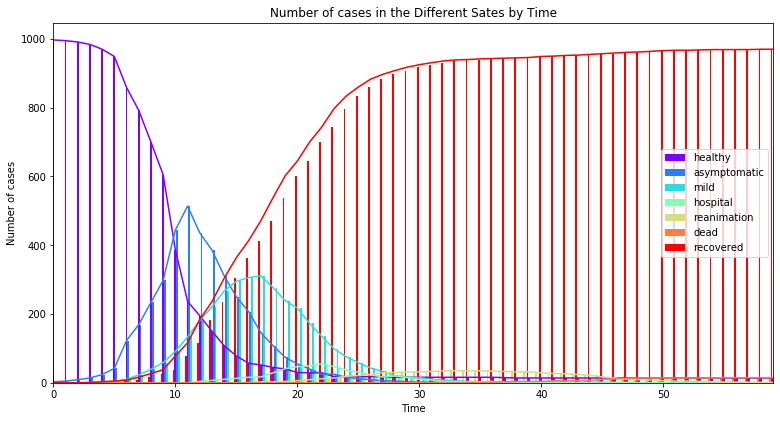

In [20]:
rcParams['figure.figsize'] = [10, 5]


states_names = [state.get_name() for state in states]
X = array(list(periods_states.keys()))

values = {state_name: [v.get('repartition').get(state_name) for v in periods_states.values()] for state_name in states_names}

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

colors = cm.rainbow(linspace(0, 1, len(states_names)))
delta = 1 / len(states_names)
for i, state_name in enumerate(states_names):
    ax.bar(X + i * delta, values.get(state_name), color=colors[i], width=delta, label=state_name)
    ax.plot(X, values.get(state_name), color=colors[i])

ax.legend()
ax.set_xlim((X.min(), X.max()))
ax.set_xlabel('Time')
ax.set_ylabel('Number of cases')
ax.set_title('Number of cases in the Different Sates by Time')
plt.savefig(os.path.join(img_path, 'nevolution.png'))
plt.plot()     

At least the shape of the curves looks realistic. It's a good sign. However, the agents seem to get infected to fast with the chosen parameters / setup.

The goal now would be to run a simulation with: 
* far more agent 
* more precise transition matrices
* adjusted parameters (contagiousity of the states etc.)
* adjusted number of move rounds per time period
* simulate the effect of a lock down by re-adjusting the parameters (less mobility of the agents, less attractivity of the cells, less unsafety in non-home cells)

## Geographical time evolution
Here we take the same map, of dimension 100x100. We divide it into 10 squares on each side. Each square could represent a region in a country. We run the simulation through time like previously. At each time period, we count the number of agent in each square that is diseased (or more precisely, the number of agents having their home cell in this square and being in one of the states *asymptomatic*, *mild*, *hospitalized* or *reanimation*).

First we associate each square to its agents:

In [21]:
from itertools import product

id2cell = {cell.get_id(): cell for cell in cells}
square_mapping = {(i, j): [] for (i, j) in product(range(10), range(10))}

for agent in agents:
    pos_home_cell = id2cell.get(agent.get_home_cell_id()).get_position()
    square_mapping[int(pos_home_cell[0] / 10), int(pos_home_cell[1] / 10)] += [agent.get_id()]

Then we run a simulation like before (re-initializing first the state of all the agents to *healthy*). At each time period, we count the number of diseased agent in each square:

In [22]:
# Reset all the agents to healthy state
for agent in agents:
    agent.set_state(state0)

disease_states = [1, 2, 3, 4]  # id of the states corresponding to diseased

# Infect a random agent in the map
infected_agent_id = choice(range(N_AGENTS))
map.get_agent(infected_agent_id).get_infected()

square_mappings_ndiseased = {}
for i in range(N_PERIODS):
    for j in range(N_MOVES_PER_PERIOD):
        map.make_move()
    map.forward_all_cells()
    square_mapping_ndiseased = {(i, j): 0 for (i, j) in product(range(10), range(10))}
    for k, v in square_mapping.items():  # iterate through the squares
        for agent_id in v:  # iterate through the agents of the square
            state_id = map.get_agent(agent_id).get_state().get_id()  # state id of agent
            increment = 1 if state_id in disease_states else 0
            square_mapping_ndiseased[k] += increment  # increment value of square if agent diseased
    square_mappings_ndiseased[i] = square_mapping_ndiseased

Here we compute the maximal number of agents having been diseased in squares during the simulation, in order to calibrate the scale of the coming heatmap:

In [23]:
max_diseased = max([max(list(smn.values())) for smn in square_mappings_ndiseased.values()])

And finally, we define a function returning the image (heatmap) of our map for a given day. The image is a heatmap where each square has a color accordingly to the number of diseased agents it contains this day.

We produce an image for each day and join them into a gif:

In [24]:
%%capture

def get_image_map(day):
    """ draw the heatmap for a given day """
    fig, ax = plt.subplots(figsize=(10, 5))
    data = zeros((10, 10))
    for k, v in square_mappings_ndiseased[day].items():
        data[k[0], k[1]] = v

    ax = sns.heatmap(data, 
                     linewidth=0, 
                     vmin=0, 
                     vmax=max_diseased, 
                     cmap=sns.cm.rocket_r, 
                     xticklabels=False, 
                     yticklabels=False)
    ax.set_title(f'Number of Diseased Agents by Region on the Map\nDay {day}')
    ax.tick_params(left=False, bottom=False)
    # Used to return the plot as an image array
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return image

    
imageio.mimsave(os.path.join(img_path, 'mapevolution.gif'), 
                [get_image_map(day) for day in list(square_mappings_ndiseased.keys())], 
                fps=6)

And here is the result, we can see the evolution of diseased people in the different regions of the maps through the time:

In [25]:
from IPython.display import HTML

HTML('<img src="../img/mapevolution.gif">')